In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import bt

In [32]:
from pymarkowitz import *

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Backtesting
- **Pymarkowitz** is designed to allow for easy integration with backtesting libraries.
- In this demo, I will show how to define it successfully using a Config Class


### Example: Backtesting with SPDR Sector ETFs
- RWR, XLB, XLI, XLY, XLP, XLE, XLF, XLU, XLV, XLK, VS SPY

In [137]:
data = bt.get('spy, rwr, xlb, xli, xly, xlp, xle, xlf, xlu, xlv, xlk', start='2005-01-01')

### Configuration
- Below is a sample configuration format
- Lookback is the number of days to look back to compute the optimization
- Other are arguments to be passed into pymarkowitz modules to customize optimization and calculation techniques


- Here we will define moment/beta calculation methods to be default, so empty dictionaries
- Objective is to maximize sharpe ratio at all time

In [138]:
class Config:
    lookback = 30
    calc_return_dict = {"method": "daily"}
    calc_mean_return_dict = {"method": "arithmetic"}
    calc_moment_dict = {}
    calc_beta_dict = {}
    beta = "spy"
    objective = {"objective_type": "min_volatility"}
    constraints = [{"constraint_type": "weight", "weight_bound": (0, 0.25), "leverage": 1}]

### Customized Algo
- Based on bt.Algo, I wrote a customized function to integrate **pymarkowitz** so you can set up the Configuration and run it smoothly
- Here is the raw code of the strategy, you can also import it directly through the **pymarkowitz.Backtester** 

In [139]:
class WeighMarkowitz(bt.Algo):

    def __init__(self, Config):
        super(WeighMarkowitz, self).__init__()
        self.lookback = Config.lookback
        self.beta = Config.beta
        self.config = Config

    def __call__(self, target):
        selected = target.temp['selected']
        non_benchmark = [asset for asset in selected if asset != self.beta]

        t0 = target.universe[selected].index.get_loc(target.now)
        if t0 >= self.lookback:
            price_mat = target.universe[selected].iloc[t0 - self.lookback:t0].dropna(how='any')
            ret_generator = ReturnGenerator(price_mat)
            
            daily_return = ret_generator.calc_return(**self.config.calc_return_dict)
            mean_return = ret_generator.calc_mean_return(**self.config.calc_mean_return_dict)[non_benchmark]
            mom_generator = MomentGenerator(daily_return[non_benchmark])
            mom_matrix = mom_generator.calc_cov_mat(**self.config.calc_moment_dict)
            beta_vec = mom_generator.calc_beta(beta_vec=daily_return[self.beta], **self.config.calc_beta_dict)
        
            PortOpt = Optimizer(mean_return, mom_matrix, beta_vec)
            PortOpt.add_objective(self.config.objective["objective_type"], **{objective_arg: self.config.objective[objective_arg] for objective_arg in self.config.objective if objective_arg not in ["objective_type"]})
            for c in self.config.constraints:
                PortOpt.add_constraint(c["constraint_type"], **{c_arg: c[c_arg] for c_arg in c if c_arg not in ["constraint_type"]})
            PortOpt.solve()
            target.temp['weights'] = PortOpt.summary()[0]
        return True


### Setting up strategy
- Comparing with Benchmark such as Buy and Hold with SPY

In [140]:
s1 = bt.Strategy('s1', [bt.algos.RunWeekly(),
                       bt.algos.SelectAll(),
                       WeighMarkowitz(Config),
                       bt.algos.Rebalance()])
test1 = bt.Backtest(s1, data)

In [141]:
s2 = bt.Strategy('s2', [bt.algos.RunWeekly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])
test2 = bt.Backtest(s2, data[['spy']].iloc[Config.lookback:])

In [142]:
res = bt.run(test1, test2)

s1
0% [############################# ] 100% | ETA: 00:00:00s2
0% [############################# ] 100% | ETA: 00:00:00

### Result
- Historical Return
- Key Statistics
- Weight Diagram

- In this case strategy 1 is slightly less volatile and generates higher return since 2005
- Intuitively, from 2008 - 2010, the algorithm never entered the Financial Sector ETF and REITs Sector ETF, which matches nicely with the fact that these two sectors were the most volatile and hardest-hit during the Great Recession

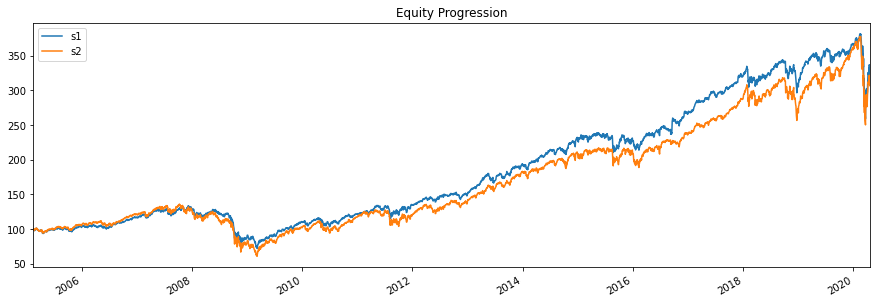

In [143]:
%matplotlib inline
res.plot()

In [144]:
res.display()

Stat                 s1          s2
-------------------  ----------  ----------
Start                2005-02-14  2005-02-14
End                  2020-04-24  2020-04-24
Risk-free rate       0.00%       0.00%

Total Return         232.61%     217.44%
Daily Sharpe         0.58        0.49
Daily Sortino        0.89        0.75
CAGR                 8.23%       7.90%
Max Drawdown         -45.96%     -55.19%
Calmar Ratio         0.18        0.14

MTD                  11.64%      9.78%
3m                   -10.97%     -13.42%
6m                   -7.43%      -4.77%
YTD                  -9.46%      -11.57%
1Y                   -5.13%      -1.19%
3Y (ann.)            4.96%       8.14%
5Y (ann.)            6.97%       8.12%
10Y (ann.)           11.17%      11.06%
Since Incep. (ann.)  8.23%       7.90%

Daily Sharpe         0.58        0.49
Daily Sortino        0.89        0.75
Daily Mean (ann.)    9.17%       9.55%
Daily Vol (ann.)     15.80%      19.70%
Daily Skew           -0.36       -0.02
Dai

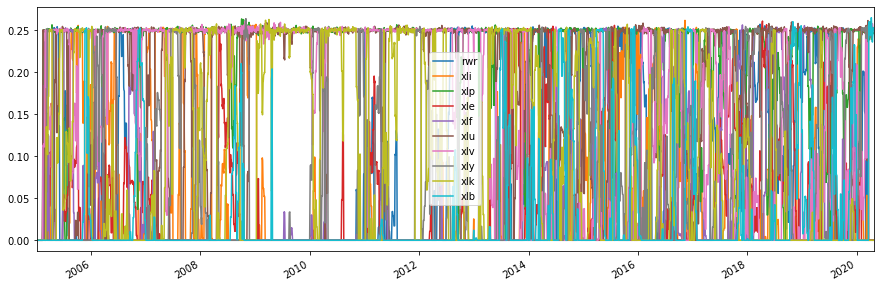

In [145]:
res.plot_security_weights()

In [146]:
### For Interactive to see individual weights clearer use Plotly
weight_df = pd.melt(res.get_security_weights().reset_index(), id_vars='index')
px.line(weight_df, x='index', y='value', color='variable')